# Calculation of Feedforward and Error backpropagation in small neural networks

This script helps to calculate the output values and weights for single neurons of basic neural networks.
This is done by changing the values in the Main at the end of this script.
This notebook is reusing code of the IAM chair of the RWTH Aachen University. 




There is no guarantee, that this script has 0 errors

---



## Functionality

The type of network achitecture for which this code can be used for is shown in the picture below.


If you want to calculate the update of the weight, you can apply the same formula as for the weights, because the bias has the input -1, that is flipping the sign of the delta term.

weight update: w = w - eta * grad * input

bias update:   b = b - eta * grad * input

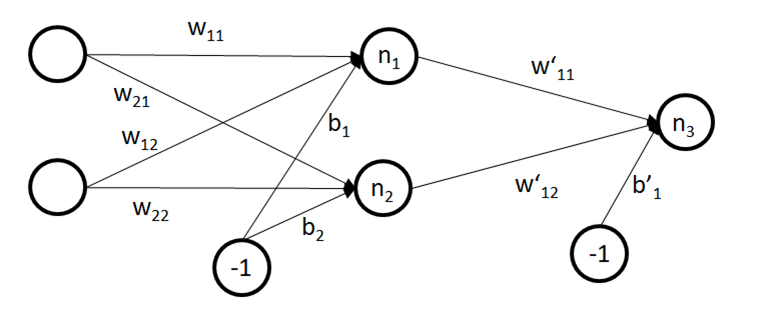

In [ ]:
# from Ex9
import numpy as np
import matplotlib.pyplot as plt

## Define functions

In [ ]:
class Layer:
  '''
  This class should provide the general functionality of each layer.
  '''

  def forward(self,x):
    raise NotImplementedError

  def backward(self,x):
    raise NotImplementedError

  def update(self,x):
    raise NotImplementedError




In [ ]:
class Dense(Layer):
    '''
    Every object of this class has its own weight and bias tensor. 
    Initial values are provided by the user to adapt the layer to the task given in the exam.
    '''
    def __init__(self, name, n,weights,bias,bias_choice):
        self.name = name
        self.n = n
        self.w = weights                                  # shape (1,1,input_dim,output_dim)
        self.bias_choice = bias_choice
        if self.bias_choice == True:
          self.b = bias.reshape((n,1))             # shape (1,1,n)
        else:
          self.b = np.zeros((n,1))
        
        self.gradient = None
        self.grad_w = None
        self.grad_b = None
    
        self.input_shape = None
    
    def forward(self, input):

        self.input = input
        self.input_shape = self.input.shape
        
        self.output = self.w @ self.input - self.b

        print(f"{self.name} output:\n {self.output}")

        return self.output

    def backward(self, gradient):
        """Backward pass of the layer."""
        self.gradient = gradient

        self.new_gradient = np.transpose(self.w,[1,0]) @ self.gradient
        self.new_gradient = self.new_gradient.reshape(self.input_shape)
        

        print(f"{self.name} gradient:\n {self.new_gradient}")

        return self.new_gradient

    def update(self, eta):
        ''' Update the weight and bias values'''

        # w(t+1) = w(t) - eta * grad(w.r.t. w)L(w(t))
        self.grad_w = self.gradient @ np.transpose(self.input,[1,0])       # shape x so that the image is in the last two axes so we can apply the @
        self.w      = self.w - eta * self.grad_w
        
        print(f"{self.name} delta_w:\n {self.grad_w}")
        print(f"{self.name} updated weights:\n {self.w}")


        if self.bias_choice == True:
           self.grad_b = np.zeros(self.b.shape)

           for b in range(self.grad_b.shape[-1]):                         # loop through neurons to update there bias
               self.grad_b[b,0] += self.gradient[b,0]             # gradient has shape(ima,1,1,b), so only ima and b are important
                          
           self.b = self.b - eta * self.grad_b
           print(f"{self.name} delta_b:\n {self.grad_b}")
           print(f"{self.name} updated bias:\n {self.b}")
        
        pass

In [ ]:
class ProductUnit(Layer):
    '''
    Every object of this class has its own weight and bias tensor. 
    Initial values are provided by the user to adapt the layer to the task given in the exam.
    '''
    def __init__(self, name, n,weights,bias,bias_choice):
        self.name = name
        self.n = n
        self.w = weights                                  # shape (1,1,input_dim,output_dim)
        self.bias_choice = bias_choice
        if self.bias_choice == True:
           self.b = bias.reshape((self.n,1))             # shape (1,1,n)
        else:
           self.b = np.zeros((self.n,1))
        
        self.input_shape = None
    
    def forward(self, input):

        self.input = input
        self.input_shape = self.input.shape
        self.output = np.ones((self.n,1))
        
        for i in range(self.n):
            for j in range(self.w.shape[1]):
                self.output[i,0] = self.input[j]**self.w[i,j] * self.output[i,0]

        self.output = self.output - self.b

        print(f"{self.name} output:\n {self.output}")

        return self.output

    def backward(self, gradient):

        raise NotImplementedError('Neural networks with product units can\'t be trained, because backpropagation is not implemented for product units. Use the forward method to predict the output of the network.')

    def update(self, eta):
        
        raise NotImplementedError('Neural networks with product units can\'t be trained, because backpropagation is not implemented for product units. Use the forward method to predict the output of the network.')


In [ ]:
class ReLU(Layer):
    def __init__(self,name):
        self.name = name
    
    def forward(self, input):
        self.input = input

        self.size = self.input.shape[0]
        
        self.output = np.zeros(self.input.shape)
        
        for s in range(self.size):
            self.output[s,0] = max(0,self.input[s,0])

        print(f"{self.name} output:\n {self.output}")
        
        return self.output
    
    def backward(self, gradient):
        self.gradient = gradient

        self.B = np.where(self.output > 0, 1, 0)        # check, where output>0 and set the value to 1 or else to 0
        
        gradient = self.B*self.gradient                 # remove the gradients, that are not propagated due to inactive input (input<0 -> output=0 -> gradient*ouptut=0).
        
        print(f"{self.name} gradient:\n {gradient}")

        return gradient

    def update(self, eta):
        '''activation functions shouldn't be updated'''
        pass

In [ ]:
class leakyReLU(Layer):
    def __init__(self,name,leak):
        self.name = name
        self.leak = leak

    def forward(self, input):
        self.input = input

        self.size = self.input.shape[0]
        
        self.output = np.zeros(self.input.shape)
        
        for s in range(self.size):
            self.output[s,0] = max(self.leak*self.input[s,0],self.input[s,0])

        print(f"{self.name} output:\n {self.output}")
        
        return self.output
    
    def backward(self, gradient):
        self.gradient = gradient

        self.A = np.where(self.output > 0, 1, 0)        # check, where output>0 and set the value to 1 or else to 0
        self.B = np.where(self.output < 0, self.leak,0)
        self.C = self.A+self.B
        self.new_gradient = self.C*self.gradient                 # remove the gradients, that are not propagated due to inactive input (input<0 -> output=0 -> gradient*ouptut=0).
        
        print(f"{self.name} gradient:\n {self.new_gradient}")

        return self.new_gradient

    def update(self, eta):
        '''activation functions shouldn't be updated'''
        pass

In [ ]:
class Sigmoid(Layer):
    def __init__(self,name):
        self.name = name

    def forward(self, input):
        self.input = input
        self.output = 1 / (1 + np.exp(-self.input))

        print(f"{self.name} output:\n {self.output}")

        return self.output

    def backward(self, gradient):
        self.gradient = gradient
        self.new_gradient = self.output*(1-self.output)*self.gradient

        print(f"{self.name} gradient:\n {self.new_gradient}")

        return self.new_gradient
    
    def update(self, learning_rate):
        pass

In [ ]:
class Step(Layer):
    def __init__(self,name):
        self.name = name
    
    def forward(self, input):
        self.input = input

        self.size = self.input.shape[0]
        
        self.output = np.zeros(self.input.shape)
        
        self.output = np.where(self.input >= 0, 1, 0)
        print(f"{self.name} output:\n {self.output}")
        
        return self.output
    
    def backward(self, gradient):
        self.gradient = gradient
        
        print(f"{self.name} gradient:\n {gradient}")
        
        return gradient

    def update(self, eta):
        '''activation functions shouldn't be updated'''
        pass

In [ ]:
class Network:
    def __init__(self, *layers):
        self.layers = layers
        
    def forward(self, input):
        print(f"\nForward pass:\n")
        for layer in self.layers:
            input = layer.forward(input)

        print("\n")

        return input
    
    def backward(self, gradient):
        
        print(f"\nCalculate gradients:\n")

        for layer in self.layers[-1::-1]:
            gradient = layer.backward(gradient)

        print("\n")
    
    def train(self, input, desired_out, eta):
        """
        trains the network with the given batch
        """
        pred_out = self.forward(input)
        gradient = -(desired_out - pred_out)                               # derivative of 0,5*(desired-pred)^2

        print(f"first gradient:\n {gradient}")

        self.backward(gradient)

        print(f"\nUpdate weights and bias:\n")

        for layer in self.layers:
            layer.update(eta)


## Main

Adapt the network to the given task. 

Attention: 


*   Activation functions are seperate layers.
*   Product units can't perform backpropagation. If you define a network with a product unit layer inside, then you can't train the network. Use the forward method of the class 'Network' to calculate the output for a given input.
*   It's necessary to give inputs, weights, and outputs as truly 2-dimensional tensors. So please do not remove the outer [ ] even if you want to pass a vector with shape (3,1). The bias contrary needs to be 1d. 
*   The delta_w and delta_b are not including the learning rate "eta". To update the parameters you need to calculate w = w - eta * delta_w


Implemented Error function = 0,5*(desired-pred)^2

Available layers:


*   Dense: layer of neurons with summation units
*   ProductUnit: layer of neurons with product units (not trainable)
*   ReLU
*   leakyReLU
*   Sigmoid
*   Step

Combine a Dense layer with Step as activation function to replicate the behaviour of a Perceptron!

Feel free to implement more activation functions like tanh, although i hope that linear activation units are enough for the exam.

* 

In [ ]:
input = np.array([[2],[1]])                       # input needs to be 2-dimensional column vector
desired_output = np.array([[1]])                  # output needs to be 2-dimensional column vector
eta = 0.2

d1 = Dense(name = 'd1',
           n=2,                                  # neurons
           weights=np.array([[2,0],[-1,1.5]]),   # the weights of the first neuron are stored in the first row. Column == input dimensions (= neurons in the previous layer)
           bias=np.array([1,1]),                 # bias of first neuron is stored at first position. #bias == #neurons
           bias_choice=False)                    # change to True if the layer should work with a bias
#sigm1 = Sigmoid(name='sigm1')
#relu1 = ReLU(name='relu1')
leakyrelu1 = leakyReLU(name='leakyrelu1',leak=0.05)
pu1 = ProductUnit(name = 'pu1',
                  n=2,
                  weights=np.array([[3,2],[2,2]]),
                  bias=np.array([1,0]),
                  bias_choice=True)
d2  = Dense(name = 'd2',
            n=1,
            weights=np.array([[1,0.5]]),
            bias=np.array([1]),
            bias_choice=False)

network = Network(d1,leakyrelu1,d2)                         # add the layers in the right order to the network 


#redicted_output = network.forward(input)        # train is printing the predicted output as well

network.train(input,desired_output,eta)           # train can't be used with product units, as the class Product Unit has no implementation of the backpropagation


Forward pass:

d1 output:
 [[ 4. ]
 [-0.5]]
leakyrelu1 output:
 [[ 4.   ]
 [-0.025]]
d2 output:
 [[3.9875]]


first gradient:
 [[2.9875]]

Calculate gradients:

d2 gradient:
 [[2.9875 ]
 [1.49375]]
leakyrelu1 gradient:
 [[2.9875   ]
 [0.0746875]]
d1 gradient:
 [[5.9003125 ]
 [0.11203125]]



Update weights and bias:

d1 delta_w:
 [[5.975     2.9875   ]
 [0.149375  0.0746875]]
d1 updated weights:
 [[ 0.805     -0.5975   ]
 [-1.029875   1.4850625]]
d2 delta_w:
 [[11.95      -0.0746875]]
d2 updated weights:
 [[-1.39       0.5149375]]
